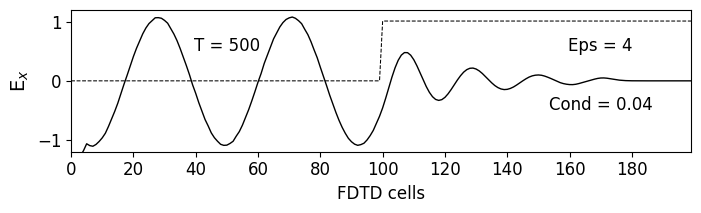

In [57]:
""" Chapter 1.7

fd3d_1_5.py: 1D FDTD
Simulation of a sinusoid wave hitting a lossy dielectric
"""
import numpy as np
from math import pi, sin
from matplotlib import pyplot as plt

ke = 200
ex = np.zeros(ke)
hy = np.zeros(ke)
ddx = 0.01 # Cell size
dt = ddx / 6e8 # Time step size
freq_in = 700e6
boundary_low = [0, 0]
boundary_high = [0, 0]

# Create Dielectric Profile
epsz = 8.854e-12
epsilon = 4
sigma = 0.04
ca = np.ones(ke)
cb = np.ones(ke) * 0.5
cb_start = 100
eaf = dt * sigma / (2 * epsz * epsilon)
ca[cb_start:] = (1 - eaf ) / (1 + eaf )
cb[cb_start:] = 0.5 / (epsilon * (1 + eaf ))
nsteps = 500

# Main FDTD Loop
for time_step in range(1, nsteps + 1):
    # Calculate the Ex field
    for k in range(1, ke):
        ex[k] = ca[k] * ex[k] + cb[k] * (hy[k - 1] - hy[k])
    # Put a sinusoidal at the low end
    pulse = sin(2 * pi * freq_in * dt * time_step)
    ex[5] += pulse
    # Absorbing Boundary Conditions
    ex[0] = boundary_low.pop(0)
    boundary_low.append(ex[1])
    ex[ke - 1] = boundary_high.pop(0)
    boundary_high.append(ex[ke - 2])
    # Calculate the Hy field
    for k in range(ke - 1):
        hy[k] = hy[k] + 0.5 * (ex[k] - ex[k + 1])
# Plot the outputs in Fig. 1.6
plt.rcParams['font.size'] = 12
plt.figure(figsize=(8, 2.25))
plt.plot(ex, color='k', linewidth=1)
plt.ylabel('E$_x$', fontsize='14')
plt.xticks(np.arange(0, 199, step=20))
plt.xlim(0, 199)
plt.yticks(np.arange(-1, 1.2, step=1))
plt.ylim(-1.2, 1.2)
plt.text(50, 0.5, 'T = {}'.format(time_step),
horizontalalignment='center')
plt.plot((0.5 / cb - 1) / 3, 'k--',
linewidth=0.75) # The math on cb is just for scaling
plt.text(170, 0.5, 'Eps = {}'.format(epsilon),
horizontalalignment='center')
plt.text(170, -0.5, 'Cond = {}'.format(sigma),
horizontalalignment='center')
plt.xlabel('FDTD cells')
plt.subplots_adjust(bottom=0.25, hspace=0.45)
plt.show()

C:\Users\Rayhan\AppData\Local\Temp\ipykernel_5516\3254443320.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  amp[m, k] = (1 / amp_in[m]) * sqrt(
C:\Users\Rayhan\AppData\Local\Temp\ipykernel_5516\3254443320.py:100: RuntimeWarning: invalid value encountered in double_scalars
  amp[m, k] = (1 / amp_in[m]) * sqrt(


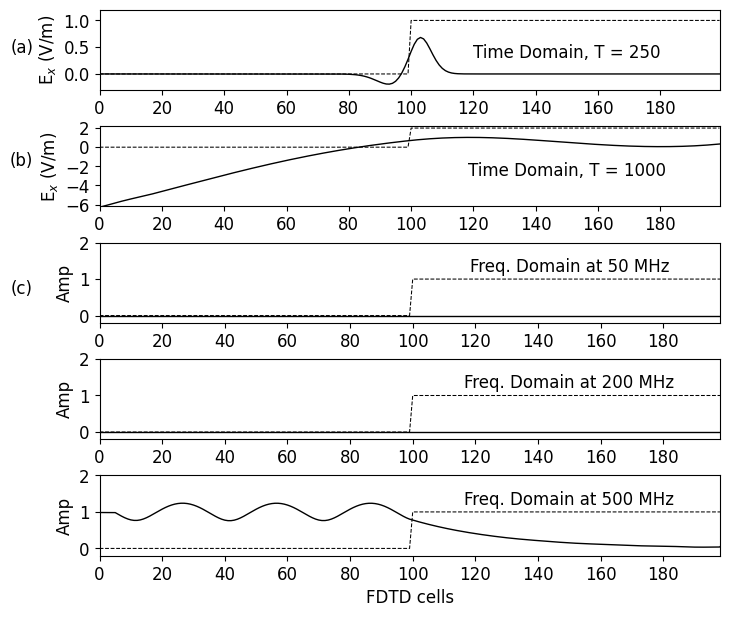

In [86]:
""" fd1d_2_3.py: 1D FDTD
Simulation of a frequency-dependent material
"""
import numpy as np
from matplotlib import pyplot as plt
from math import pi, exp, cos, sin, sqrt, atan2
ke = 200
ex = np.zeros(ke)
dx = np.zeros(ke)
ix = np.zeros(ke)
sx = np.zeros(ke)
hy = np.zeros(ke)
ddx = 0.01 # Cell size
dt = ddx / 6e8 # Time step size
number_of_frequencies = 3
freq_in = np.array((50e6, 200e6, 500e6))
t0 = 50
spread = 10
boundary_low = [0, 0]
boundary_high = [0, 0]
# Create Dielectric Profile
epsz = 8.854e-12
epsr = 2
sigma = 0.01
tau = 0.001 * 1e-6
chi = 2
k_start = 100
gax = np.ones(ke)
gbx = np.zeros(ke)
gcx = np.zeros(ke)
gax[k_start:] = 1 / (epsr + (sigma * dt / epsz) + chi * dt / tau)
gbx[k_start:] = sigma * dt / epsz
gcx[k_start:] = chi * dt / tau
del_exp = exp(-dt / tau)
# To be used in the Fourier transform
arg = 2 * np.pi * freq_in * dt
real_pt = np.zeros((number_of_frequencies, ke))
imag_pt = np.zeros((number_of_frequencies, ke))
real_in = np.zeros(number_of_frequencies)
imag_in = np.zeros(number_of_frequencies)
amp_in = np.zeros(number_of_frequencies)
phase_in = np.zeros(number_of_frequencies)
amp = np.zeros((number_of_frequencies, ke))
phase = np.zeros((number_of_frequencies, ke))
nsteps = 1000
# Dictionary to keep track of desired points for plotting
plotting_points = [
{'num_steps': 250, 'ex': None, 'scaling_factor': 1,
'gb_scaling_factor': 1, 'y_ticks': (0, 0.5, 1),
'y_min': -0.3, 'y_max': 1.2, 'y_text_loc': 0.3,
'label': '(a)', 'label_loc': 0.4},
{'num_steps': 1000, 'ex': None, 'scaling_factor': 1000,
'gb_scaling_factor': 2, 'y_ticks': (-6, -4, -2, 0, 2),
'y_min': -6.2, 'y_max': 2.2, 'y_text_loc': -3,
'label': '(b)', 'label_loc': -1.9}
]
# Main FDTD Loop
for time_step in range(1, nsteps + 1):
    # Calculate Dx
    for k in range(1, ke):
        dx[k] = dx[k] + 0.5 * (hy[k - 1] - hy[k])
    # Put a sinusoidal at the low end
    pulse = exp(-0.5 * ((t0 - time_step) / spread) ** 2)
    dx[5] = pulse + dx[5]
    # Calculate the Ex field from Dx
    for k in range(1, ke):
        ex[k] = gax[k] * (dx[k] - ix[k] - del_exp * sx[k])
        ix[k] = ix[k] + gbx[k] * ex[k]
        sx[k] = del_exp * sx[k] + gcx[k] * ex[k]
    # Calculate the Fourier transform of Ex
    for k in range(ke):
        for m in range(number_of_frequencies):
            real_pt[m, k] = real_pt[m, k] + cos(arg[m] * time_step) \
                * ex[k]
            imag_pt[m, k] = imag_pt[m, k] - sin(arg[m] * time_step) \
                * ex[k]
    # Fourier Transform of the input pulse
    if time_step < 3 * t0:
        for m in range(number_of_frequencies):
            real_in[m] = real_in[m] + cos(arg[m] * time_step) * ex[10]
            imag_in[m] = imag_in[m] - sin(arg[m] * time_step) * ex[10]
    # Absorbing Boundary Conditions
    ex[0] = boundary_low.pop(0)
    boundary_low.append(ex[1])
    ex[ke - 1] = boundary_high.pop(0)
    boundary_high.append(ex[ke - 2])
    # Calculate the Hy field
    for k in range(ke - 1):
        hy[k] = hy[k] + 0.5 * (ex[k] - ex[k + 1])
    # Save data at certain points for later plotting
    for plotting_point in plotting_points:
        if time_step == plotting_point['num_steps']:
            plotting_point['ex'] = np.copy(ex)
    # Calculate the amplitude and phase at each frequency
    for m in range(number_of_frequencies):
        amp_in[m] = sqrt(imag_in[m] ** 2 + real_in[m] ** 2)
        phase_in[m] = atan2(imag_in[m], real_in[m])

    for k in range(ke):
        amp[m, k] = (1 / amp_in[m]) * sqrt(
        (real_pt[m, k]) ** 2 + (imag_pt[m, k]) ** 2)
        phase[m, k] = atan2(imag_pt[m, k], real_pt[m, k])
        - phase_in[m]
# Plot the outputs in Fig. 2.3
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=(8, 7))

def plot_e_field(data, gb, timestep, scaling_factor,
gb_scaling_factor,
y_ticks, y_min, y_max, y_text_loc, label,
label_loc):
    """Plot of E field at a single time step"""
    plt.plot(data * scaling_factor, color='k', linewidth=1)
    plt.ylabel('E$_x$ (V/m)', fontsize='12')
    plt.xticks(np.arange(0, 199, step=20))
    plt.xlim(0, 199)
    plt.yticks(y_ticks)
    plt.ylim(y_min, y_max)
    plt.text(150, y_text_loc, 'Time Domain, T = {}'.
    format(timestep),
    horizontalalignment='center')
    plt.plot(gb * gb_scaling_factor / gb[120], 'k--',
    linewidth=0.75) # The math on gb is just for scaling
    plt.text(-25, label_loc, label, horizontalalignment=
    'center')
    return
# Plot the E field at each of the time steps saved earlier
for subplot_num, plotting_point in enumerate(plotting_points):
    ax = fig.add_subplot(5, 1, subplot_num + 1)
    plot_e_field(plotting_point['ex'], gbx,
    plotting_point['num_steps'],
    plotting_point['scaling_factor'],
    plotting_point['gb_scaling_factor'],
    plotting_point['y_ticks'], plotting_point['y_min'],
    plotting_point['y_max'],
    plotting_point['y_text_loc'],
    plotting_point['label'],
    plotting_point['label_loc'])

# Dictionary to keep track of plotting for the amplitudes
plotting_freqs = [
{'freq': freq_in[0], 'amp': amp[0], 'label': '(c)',
'x_label': ''},
{'freq': freq_in[1], 'amp': amp[1], 'label': '',
'x_label': ''},
{'freq': freq_in[2], 'amp': amp[2], 'label': '',
'x_label': 'FDTD cells'}
]
def plot_amp(data, gb, freq, label, x_label):
    """Plot of amplitude at one frequency"""
    plt.plot(data, color='k', linewidth=1)
    plt.ylabel('Amp')
    plt.xticks(np.arange(0, 199, step=20))
    plt.xlim(0, 198)
    plt.yticks(np.arange(0, 2.1, step=1))
    plt.ylim(-0.2, 2.0)
    plt.text(150, 1.2, 'Freq. Domain at {} MHz'.format
    (int(round(
    freq / 1e6))), horizontalalignment='center')
    plt.plot(gb * 1 / gb[120], 'k--',
    linewidth=0.75) # The math on gb is just for scaling
    plt.text(-25, 0.6, label, horizontalalignment='center')
    plt.xlabel(x_label)
    return
# Plot the amplitude at each of the frequencies of interest
for subplot_num, plotting_freq in enumerate(plotting_freqs):
    ax = fig.add_subplot(5, 1, subplot_num + 3)
    plot_amp(plotting_freq['amp'], gbx, plotting_freq['freq'],
    plotting_freq['label'], plotting_freq['x_label'])
plt.subplots_adjust(bottom=0.1, hspace=0.45)
plt.show()

C:\Users\Rayhan\AppData\Local\Temp\ipykernel_5516\2355444010.py:133: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


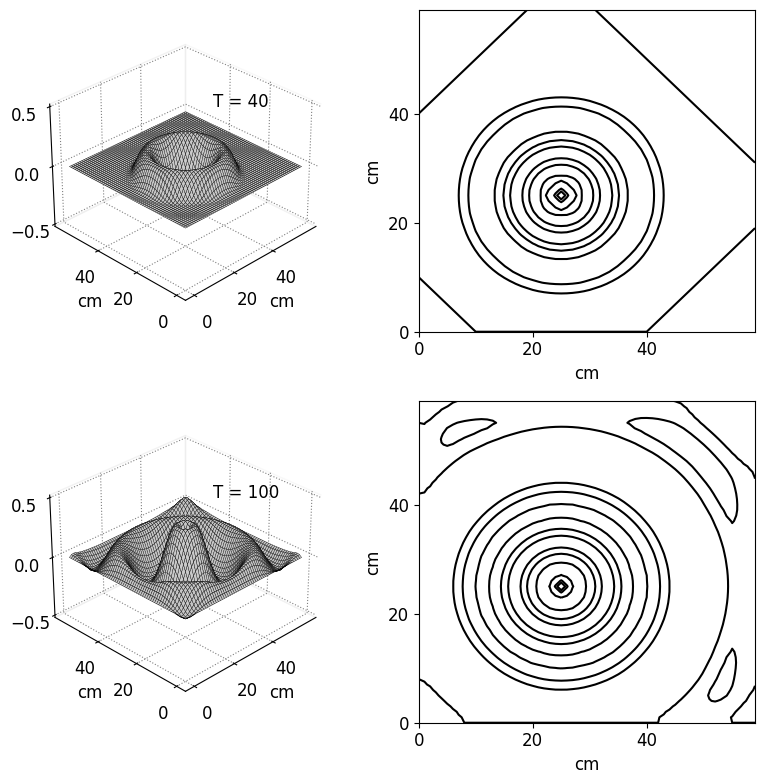

In [92]:
""" fd2d_3_2.py: 2D FDTD
TM program with the PML added
"""
import numpy as np
from math import sin, pi
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d
ie = 60
je = 60
ic = int(ie / 2 - 5)
jc = int(je / 2 - 5)
ez = np.zeros((ie, je))
dz = np.zeros((ie, je))
hx = np.zeros((ie, je))
hy = np.zeros((ie, je))
ihx = np.zeros((ie, je))
ihy = np.zeros((ie, je))
ddx = 0.01 # Cell size
dt = ddx / 6e8 # Time step size
# Create Dielectric Profile
epsz = 8.854e-12
# Pulse Parameters
t0 = 40
spread = 12
gaz = np.ones((ie, je))
# Calculate the PML parameters
gi2 = np.ones(ie)
gi3 = np.ones(ie)
fi1 = np.zeros(ie)
fi2 = np.ones(ie)
fi3 = np.ones(ie)
gj2 = np.ones(ie)
gj3 = np.ones(ie)
fj1 = np.zeros(ie)
fj2 = np.ones(ie)
fj3 = np.ones(ie)
# Create the PML as described in Section 3.2
npml = 8
for n in range(npml):
    xnum = npml - n
    xd = npml
    xxn = xnum / xd
    xn = 0.33 * xxn ** 3
    
    gi2[n] = 1 / (1 + xn)
    gi2[ie - 1 - n] = 1 / (1 + xn)
    gi3[n] = (1 - xn) / (1 + xn)
    gi3[ie - 1 - n] = (1 - xn) / (1 + xn)
    gj2[n] = 1 / (1 + xn)
    gj2[je - 1 - n] = 1 / (1 + xn)
    gj3[n] = (1 - xn) / (1 + xn)
    gj3[je - 1 - n] = (1 - xn) / (1 + xn)
    
    xxn = (xnum - 0.5) / xd
    xn = 0.33 * xxn ** 3
    
    fi1[n] = xn
    fi1[ie - 2 - n] = xn
    fi2[n] = 1 / (1 + xn)
    fi2[ie - 2 - n] = 1 / (1 + xn)
    fi3[n] = (1 - xn) / (1 + xn)
    fi3[ie - 2 - n] = (1 - xn) / (1 + xn)

    fj1[n] = xn
    fj1[je - 2 - n] = xn
    fj2[n] = 1 / (1 + xn)
    fj2[je - 2 - n] = 1 / (1 + xn)
    fj3[n] = (1 - xn) / (1 + xn)
    fj3[je - 2 - n] = (1 - xn) / (1 + xn)
nsteps = 100
# Dictionary to keep track of desired points for plotting
plotting_points = [
{'num_steps': 40, 'data_to_plot': None},
{'num_steps': nsteps, 'data_to_plot': None},
]
# Main FDTD Loop
for time_step in range(1, nsteps + 1):
    # Calculate Dz
    for j in range(1, je):
        for i in range(1, ie):
            dz[i, j] = gi3[i] * gj3[j] * dz[i, j] + \
            gi2[i] * gj2[j] * 0.5 * \
            (hy[i, j] - hy[i - 1, j] -
            hx[i, j] + hx[i, j - 1])
    # Put a Gaussian pulse in the middle
    pulse = sin(2 * pi * 1500 * 1e6 * dt * time_step)
    dz[ic, jc] = pulse
    ez = gaz * dz # Calculate the Ez field from Dz
    # Calculate the Hx field
    for j in range(je - 1):
        for i in range(ie - 1):
            curl_e = ez[i, j] - ez[i, j + 1]
            ihx[i, j] = ihx[i, j] + curl_e
            hx[i, j] = fj3[j] * hx[i, j] + fj2[j] * \
            (0.5 * curl_e + fi1[i] * ihx[i, j])
    # Calculate the Hy field
    for j in range(0, je - 1):
        for i in range(0, ie - 1):
            curl_e = ez[i, j] - ez[i + 1, j]
            ihy[i, j] = ihy[i, j] + curl_e
            hy[i, j] = fi3[i] * hy[i, j] - fi2[i] * \
            (0.5 * curl_e + fj1[j] * ihy[i, j])
    # Save data at certain points for later plotting
    for plotting_point in plotting_points:
        if time_step == plotting_point['num_steps']:
            plotting_point['data_to_plot'] = np.copy(ez)
# Plot Fig. 3.4
plt.rcParams['font.size'] = 12
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linestyle'] = 'dotted'
fig = plt.figure(figsize=(8, 8))
X, Y = np.meshgrid(range(je), range(ie))
def plot_e_field(ax, data, timestep):
    """3d Plot of E field at a single time step"""
    ax.set_zlim(-0.5, 0.5)
    ax.view_init(elev=30., azim=-135)
    ax.plot_surface(X, Y, data, rstride=1, cstride=1,
    color='white',
    edgecolor='black', linewidth=.25)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel(r' $E_{Z}$', rotation=90, labelpad=10,
    fontsize=14)
    ax.set_xlabel('cm')
    ax.set_ylabel('cm')
    ax.set_xticks(np.arange(0, 60, step=20))
    ax.set_yticks(np.arange(0, 60, step=20))
    ax.set_zticks([-0.5, 0, 0.5])
    ax.text2D(0.6, 0.7, "T = {}".format(timestep),
    transform=ax.transAxes)
    ax.xaxis.pane.fill = ax.yaxis.pane.fill = \
    ax.zaxis.pane.fill = False
    plt.gca().patch.set_facecolor('white')
    ax.dist = 11
def plot_e_field_contour(ax, data):
    """Contour Plot of E field at a single time step"""
    CP = plt.contour(X, Y, data, colors='black',
    linestyles='solid')
    CP.collections[4].remove()
    # above removes extraneous outer contour display
    ax.set_xticks(np.arange(0, 60, step=20))
    ax.set_yticks(np.arange(0, 60, step=20))
    plt.xlabel('cm')
    plt.ylabel('cm')
# Plot the E field at each of the time steps saved earlier
for subplot_num, plotting_point in enumerate(plotting_points):
    ax = fig.add_subplot(2, 2, subplot_num * 2 + 1,
    projection='3d')
    plot_e_field(ax, plotting_point['data_to_plot'],
    plotting_point['num_steps'])
    ax = fig.add_subplot(2, 2, subplot_num * 2 + 2)
    plot_e_field_contour(ax, plotting_point['data_to_plot'])
plt.tight_layout()
plt.subplots_adjust(left=0.05)
plt.show()

C:\Users\Rayhan\AppData\Local\Temp\ipykernel_5516\3667244184.py:154: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


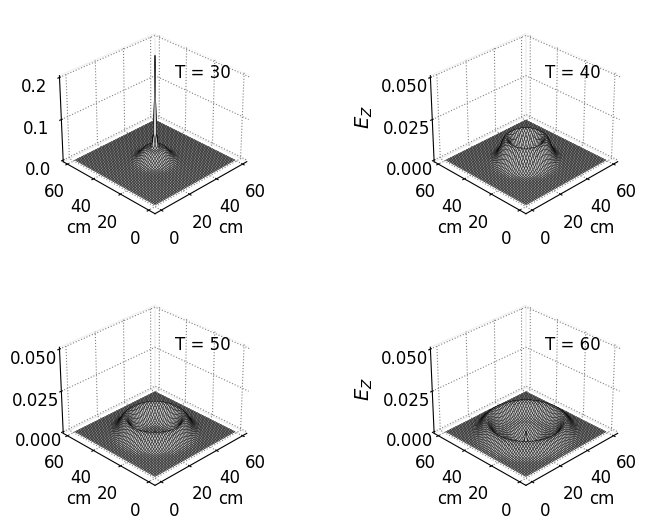

In [97]:
""" fd2d_4_1.py: 3D FDTD
Dipole in free space
"""
import numpy as np
from math import exp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import numba

ie = 60
je = 60
ke = 60
ic = int(ie / 2)
jc = int(je / 2)
kc = int(ke / 2)

ex = np.zeros((ie, je, ke))
ey = np.zeros((ie, je, ke))
ez = np.zeros((ie, je, ke))
dx = np.zeros((ie, je, ke))
dy = np.zeros((ie, je, ke))
dz = np.zeros((ie, je, ke))
hx = np.zeros((ie, je, ke))
hy = np.zeros((ie, je, ke))
hz = np.zeros((ie, je, ke))
gax = np.ones((ie, je, ke))
gay = np.ones((ie, je, ke))
gaz = np.ones((ie, je, ke))

ddx = 0.01 # Cell size
dt = ddx / 6e8 # Time step size
epsz = 8.854e-12

# Specify the dipole
gaz[ic, jc, kc - 10:kc + 10] = 0
gaz[ic, jc, kc] = 1

# Pulse Parameters
t0 = 20
spread = 6

nsteps = 60

# At each of these four time steps, save the E field data
# for plotting at the end
plotting_points = [
{'num_steps': 30, 'data_to_plot': None, 'z_scale': 0.20},
{'num_steps': 40, 'data_to_plot': None, 'z_scale': 0.05},
{'num_steps': 50, 'data_to_plot': None, 'z_scale': 0.05},
{'num_steps': 60, 'data_to_plot': None, 'z_scale': 0.05},
]

# Functions for Main FDTD Loop
@numba.jit(nopython=True)
def calculate_d_fields(ie, je, ke, dx, dy, dz, hx, hy, hz):
    """ Calculate the Dx, Dy, and Dz fields """
    for i in range(1, ie):
        for j in range(1, je):
            for k in range(1, ke):
                dx[i, j, k] = dx[i, j, k] + 0.5 * (
                hz[i, j, k] - hz[i, j - 1, k] -
                hy[i, j, k] + hy[i, j, k - 1])
    for i in range(1, ie):
        for j in range(1, je):
            for k in range(1, ke):
                dy[i, j, k] = dy[i, j, k] + 0.5 * (
                hx[i, j, k] - hx[i, j, k - 1] -
                hz[i, j, k] + hz[i - 1, j, k])
    for i in range(1, ie):
        for j in range(1, je):
            for k in range(1, ke):
                dz[i, j, k] = dz[i, j, k] + 0.5 * (
                hy[i, j, k] - hy[i - 1, j, k] -
                hx[i, j, k] + hx[i, j - 1, k])
    return dx, dy, dz

@numba.jit(nopython=True)
def calculate_e_fields(ie, je, ke, dx, dy, dz,
gax, gay, gaz, ex, ey, ez):
    """ Calculate the E field from the D field """
    for i in range(0, ie):
        for j in range(0, je):
            for k in range(0, ke):
                ex[i, j, k] = gax[i, j, k] * dx[i, j, k]
                ey[i, j, k] = gay[i, j, k] * dy[i, j, k]
                ez[i, j, k] = gaz[i, j, k] * dz[i, j, k]
    return ex, ey, ez

@numba.jit(nopython=True)
def calculate_h_fields(ie, je, ke, hx, hy, hz, ex, ey, ez):
    """ Calculate the Hx, Hy, and Hz fields """
    for i in range(0, ie):
        for j in range(0, je - 1):
            for k in range(0, ke - 1):
                hx[i, j, k] = hx[i, j, k] + 0.5 * (
                ey[i, j, k + 1] - ey[i, j, k] -
                ez[i, j + 1, k] + ez[i, j, k])
    for i in range(0, ie - 1):
        for j in range(0, je):
            for k in range(0, ke - 1):
                hy[i, j, k] = hy[i, j, k] + 0.5 * (
                ez[i + 1, j, k] - ez[i, j, k] -
                ex[i, j, k + 1] + ex[i, j, k])
    for i in range(0, ie - 1):
        for j in range(0, je - 1):
            for k in range(0, ke):
                hz[i, j, k] = hz[i, j, k] + 0.5 * (
                ex[i, j + 1, k] - ex[i, j, k] -
                ey[i + 1, j, k] + ey[i, j, k])
    return hx, hy, hz

# Main FDTD Loop
for time_step in range(1, nsteps + 1):
    # Calculate the D Fields
    dx, dy, dz = calculate_d_fields(ie, je, ke, dx, dy, dz, hx, hy, hz)
    # Add the source at the gap
    pulse = exp(-0.5 * ((t0 - time_step) / spread) ** 2)
    dz[ic, jc, kc] = pulse
    # Calculate the E field from the D field
    ex, ey, ez = calculate_e_fields(ie, je, ke, dx, dy, dz,
    gax, gay, gaz, ex, ey, ez)
    # Calculate the H fields
    hx, hy, hz = calculate_h_fields(ie, je, ke, hx, hy, hz, ex, ey, ez)

    # Save data at certain points for later plotting
    for plotting_point in plotting_points:
        if time_step == plotting_point['num_steps']:
            plotting_point['data_to_plot'] = np.copy(ez)
# Plot Fig. 4.3
plt.rcParams['font.size'] = 12
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linestyle'] = 'dotted'
fig = plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(range(je), range(ie))

def plot_e_field(ax, data, timestep, scale):
    """3d Plot of E field at a single time step"""
    ax.set_zlim(0, scale)
    ax.view_init(elev=30., azim=-135)
    ax.plot_surface(X, Y, data[:, :, kc], rstride=1, cstride=1,
    color='white', edgecolor='black', linewidth=0.25)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel(r' $E_{Z}$', rotation=90, labelpad=10, fontsize=14)
    ax.set_zticks([0, scale / 2, scale])
    ax.set_xlabel('cm')
    ax.set_ylabel('cm')
    ax.set_xticks(np.arange(0, 61, step=20))
    ax.set_yticks(np.arange(0, 61, step=20))
    ax.text2D(0.6, 0.7, "T = {}".format(timestep),
    transform=ax.transAxes)
    ax.xaxis.pane.fill = ax.yaxis.pane.fill = \
    ax.zaxis.pane.fill = False
    plt.gca().patch.set_facecolor('white')
    ax.dist = 11

# Plot the E field at each of the four time steps saved earlier
for subplot_num, plotting_point in enumerate(plotting_points):
    ax = fig.add_subplot(2, 2, subplot_num + 1, projection='3d')
    plot_e_field(ax, plotting_point['data_to_plot'],
    plotting_point['num_steps'],
    plotting_point['z_scale'])

plt.subplots_adjust(bottom=0.05, left=0.05)
plt.show()

# Notes:

Yang terakhir itu belum, masih fig 4.3, yang harus ditiru fig 4.4